## Лабораторная работа 7. Подбор параметров и сборка пайплайна

In [ ]:
import pandas as pd

train_df = pd.read_csv('./train_dataset.csv')
val_df = pd.read_csv('./val_dataset.csv')
test_df = pd.read_csv('./test_dataset.csv')

X_train_W2V = pd.read_csv('./X_train_vec_W2V.csv')
X_val_W2V = pd.read_csv('./X_val_vec_W2V.csv')
X_test_W2V = pd.read_csv('./X_test_vec_W2V.csv')

X_train_W2V['label'] = train_df['popularity']
X_val_W2V['label'] = val_df['popularity']
X_test_W2V['label'] = test_df['popularity']


X_train = X_train_W2V.drop(columns='label').values
y_train = X_train_W2V['label'].values

X_val = X_val_W2V.drop(columns='label').values
y_val = X_val_W2V['label'].values

X_test = X_test_W2V.drop(columns='label').values
y_test = X_test_W2V['label'].values

In [8]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([('clf', RandomForestClassifier())])

#сетка параметров
parameters = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__max_features': ['sqrt', 'log2']
}

halving_search = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    cv=5,
    factor=2,
    random_state=0,
)


In [9]:
halving_search.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('clf',
                                               RandomForestClassifier())]),
                    factor=2,
                    param_grid={'clf__max_depth': [None, 10, 20, 30],
                                'clf__max_features': ['sqrt', 'log2'],
                                'clf__n_estimators': [50, 100, 200]},
                    random_state=0)

In [10]:
best_parameters = halving_search.best_params_
print("Лучшие параметры:")
for param_name in sorted(best_parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Лучшие параметры:
clf__max_depth: 30
clf__max_features: sqrt
clf__n_estimators: 200


In [11]:
from sklearn.metrics import classification_report

y_pred_optimized = halving_search.predict(X_test)
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred_optimized, digits=4))


Отчет классификации:
              precision    recall  f1-score   support

           0     0.6250    0.6231    0.6240       658
           1     0.6225    0.6244    0.6235       655

    accuracy                         0.6238      1313
   macro avg     0.6238    0.6238    0.6238      1313
weighted avg     0.6238    0.6238    0.6238      1313



<Figure size 1000x600 with 0 Axes>

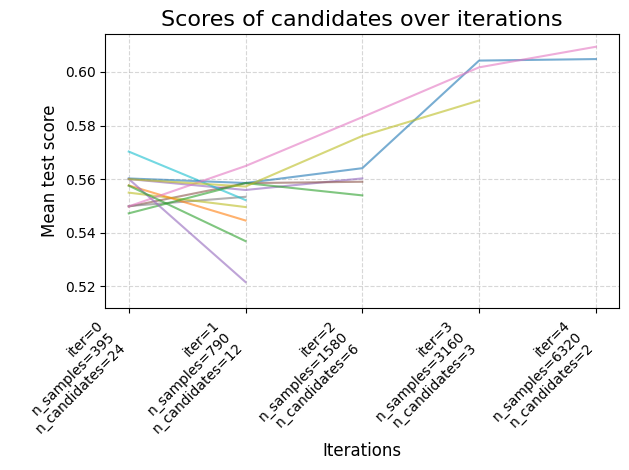

In [13]:
import matplotlib.pyplot as plt

results = pd.DataFrame(halving_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)

mean_scores = results.pivot(
    index="iter",
    columns="params_str",
    values="mean_test_score",
)

plt.figure(figsize=(10, 6))
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search.n_resources_[i]}\nn_candidates={halving_search.n_candidates_[i]}"
    for i in range(halving_search.n_iterations_)
]

ax.set_xticks(range(halving_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Scores of candidates over iterations", fontsize=16)
ax.set_ylabel("Mean test score", fontsize=12)
ax.set_xlabel("Iterations", fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Подготовка итогового классификатора

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf =  RandomForestClassifier(
        n_estimators = 200,
        criterion = 'gini',
        max_depth = 30,
        max_features = 'sqrt',
        class_weight = 'balanced',
        random_state = 42
)
results = []
train_model(X_train_W2V, X_val_W2V, X_test_W2V, name_dataset='Word2Vec', classifier=clf_rf)

In [19]:
results_df = pd.DataFrame(results)
results_df

,Vectorizer,Model,Dataset,Accuracy,Precision,Recall,F1-score
0,Word2Vec,RandomForestClassifier,Validation,0.601254,0.601248,0.601246,0.601246
1,Word2Vec,RandomForestClassifier,Test,0.620716,0.620717,0.620717,0.620716


Сборка пайплайна

In [24]:
from sklearn.pipeline import Pipeline
import joblib
import re
from sklearn.base import BaseEstimator, TransformerMixin
import gensim
import nltk
import pymorphy3
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [14]:
nltk.download('stopwords')
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
class TextPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.morph = pymorphy3.MorphAnalyzer()
        self.stop_words = set(stopwords.words('russian'))

    def fit(self, corpus):
        return self

    def transform(self, corpus):
        return [self.clean_text(text) for text in corpus]


    def is_cyrillic(self, word):
       return bool(re.fullmatch(r'[а-яё]+', word))

    def clean_text(self, text):
       text = text.lower()
       text = re.sub(r'http\S+|www\S+|https\S+', '', text)
       text = re.sub(r'[^a-zа-яё\s]', '', text)

       tokens = text.split()

       cleaned_tokens = []
       for token in tokens:
           if token in stop_words:
               continue
           if self.is_cyrillic(token):
               token = morph.parse(token)[0].normal_form
           cleaned_tokens.append(token)

       return ' '.join(cleaned_tokens)

In [21]:
example_text = "Разработчики разработали разработку!"
preprocessor = TextPreprocessing()
tokens = preprocessor.transform([example_text])
tokens

['разработчик разработать разработка']

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
        self.vector_size = word2vec_model.vector_size

    def transform(self, texts):
        vectors = []
        for text in texts:
            words = text.split() if isinstance(text, str) else text

            word_vectors = []
            for word in words:
                if word in self.word2vec_model.wv:
                    word_vectors.append(self.word2vec_model.wv[word])
                else:
                    word_vectors.append(np.zeros(self.vector_size))

            if word_vectors:
                vectors.append(np.mean(word_vectors, axis=0))
            else:
                vectors.append(np.zeros(self.vector_size))

        return np.array(vectors)

In [ ]:
# подгружаем предобученный векторизатор и классификатор
vectorizer = Word2Vec.load('./W2V_pretrained.bin')
classifier = joblib.load('./RandomForestClassifier_for_Word2Vec.joblib')
model_sentiment_analysis = Pipeline(
    [('preproc', TextPreprocessing()),
     ('vec', Word2VecVectorizer(vectorizer)),
     ('clf', classifier)])

In [43]:
model_sentiment_analysis.predict(['С сегодняшнего дня Skype прекращает свою работу Press 🫡 для легенды'])

array([0])